<a href="https://www.kaggle.com/code/leonanvasconcelos/object-detection-with-pure-computer-vision?scriptVersionId=212300969" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/leonanvasconcelos/object-detection-with-pure-computer-vision?scriptVersionId=211373957" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Requirements

**Scenario Description: Automated Fruit Detection and Analysis in Agricultural Imaging**
""**Objective:**  
Develop an automated system for detecting, counting, and analyzing round objects (such as fruitgs using advanced image processing and computer vision techniques. This system aims to enhance yield estimation, monitor crop health, and optimize harvesting processes by leveraging high-resolution images captured from various sources like drones or ground-based cameras.

**Computer Vision Methods:**

1. **Image Acquisition:**
   - **Data Collection:** Utilize drones, satellite imagery, or fixed cameras to capture high-resolution images of orchards, plantations, or fruit-bearing areas. Ensure consistent lighting conditions and optimal angles to facilitate accurate detection.
   - **Image Input Options:** Support both direct image file paths (`path_image`) and Base64-encoded image strings (`image64`) to provide flexibility in data sourcing.

2. **Preprocessing:**
   - **Resizing:** Use `resize_image` to standardize image dimensions, ensuring uniformity across different datasets and optimizing processing speed without losing critical details.
   - **Aspect Ratio Adjustment:** Apply `crop_image_to_aspect_ratio` to maintain desired aspect ratios (e.g., 4:3 or 3:4) based on image orientation, enhancing the focus on relevant regions.

3. **Image Enhancement:**
   - **Contrast Enhancement:** Implement `apply_clahe` to improve image contrast adaptively, making fruits more distinguishable from the background.
   - **Color Smoothing:** Utilize `smooth_color` to reduce color noise and enhance the clarity of fruit regions, facilitating better segmentation.

4. **Color Filtering and Mask Generation:**
   - **Color Space Conversion:** Convert images to appropriate color spaces (HSV or LAB) using OpenCV's `cvtColor` for effective color-based segmentation.
   - **Color Range Selection:** Employ `filter_color` to isolate target fruits based on predefined color ranges, generating binary masks that highlight potential fruit regions.
   - **Morphological Operations:** Apply functions like `remove_salt_and_pepper`, `close_mask_circle`, and `expand_mask_circle` to refine masks by eliminating noise, closing gaps, and expanding regions to cover entire fruits.

5. **Foreground and Background Segmentation:**
   - **Foreground Masking:** Combine multiple masks using weighted summation to create a comprehensive foreground mask that accurately represents fruit regions.
   - **Background Masking:** Invert the foreground mask to delineate background areas, enabling separate processing if needed.

6. **Object Detection:**
   - **Circle Detection:** Utilize `detect_circles` with OpenCV's `SimpleBlobDetector` to identify circular shapes corresponding to fruits. Parameters like circularity, convexity, and inertia ratio are fine-tuned to enhance detection accuracy.
   - **Overlap Handling:** Implement `remove_overlapping_circles` to eliminate duplicate detections and ensure each fruit is counted only once.
   - **Visualization:** Use `draw_circles` to annotate detected fruits on the original image, providing visual confirmation and aiding in result verification.

7. **K-Means Clustering (Optional):**
   - **Color Quantization:** Apply `kmeans_recolor` to reduce the color palette of the image, simplifying color variations and potentially improving detection performance in complex backgrounds.
   - **Visualization:** Generate clustered images to analyze color distributions and adjust clustering parameters as needed.

8. **EXIF Metadata Extraction:**
   - **Metadata Retrieval:** Use `extract_metadata_EXIF` to obtain valuable information such as GPS coordinates, capture date, camera model, and manufacturer from image metadata.
   - **Data Integration:** Incorporate EXIF data into the final report for contextual insights, enabling spatial and temporal analysis of fruit distribution and growth patterns.

9. **Post-processing and Reporting:**
   - **Result Compilation:** Aggregate detection results, including the number of fruits detected and accuracy metrics, into a structured JSON format using `format_result`.
   - **Image Saving:** Save annotated images with detection overlays and preprocessed images for record-keeping and further analysis using `save_image`.
   - **Interactive Tuning (Debugging):** Provide functions like `tunning_blur`, `tunning_color`, and `tunning_BlobCircles` with OpenCV trackbars for real-time parameter adjustments, facilitating optimization during development and deployment.

10. **Batch Processing and Automation:**
    - **Batch Mode Support:** Enable processing of multiple images in a directory through the `test_directory` function, automating the detection pipeline and generating summarized accuracy reports.
    - **Error Handling:** Implement robust error handling to manage issues like invalid image paths, decoding errors, and missing EXIF data, ensuring the system's resilience and reliability.

**Benefits:**

- **Efficiency:** Automates the time-consuming process of fruit counting and analysis, allowing farmers and agricultural professionals to focus on decision-making and field operations.
- **Accuracy:** Enhances detection precision through advanced filtering, morphological operations, and customizable parameters, reducing human error and ensuring reliable yield estimates.
- **Scalability:** Capable of handling large datasets from extensive agricultural fields, supporting scalability as operations grow.
- **Cost-Effective:** Reduces the need for manual labor in fruit counting and monitoring, lowering operational costs and increasing overall productivity.

By implementing this comprehensive system, agricultural stakeholders can achieve enhanced monitoring of crop yields, better resource allocation, and informed strategies for crop management, ultimately contributing to increased agricultural efficiency and sustainability.

In [1]:
# Requirements

from PIL import Image as PILImage
import os, random, io, base64, json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display


#!jupyter nbextension install --py widgetsnbextension
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!jupyter nbextension enable --py widgetsnbextension
!jupyter labextension enable @jupyter-widgets/jupyterlab-manager

import ipywidgets as widgets

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
# Import functions created by the author available on GitHub
import os
import cv2

# Clone the repository only if it doesn't exist
#!rm -r ./ObjectDetectionPureCV
if not os.path.exists('./ObjectDetectionPureCV'):
    !git clone https://github.com/LeonanUCM/ObjectDetectionPureCV.git

import sys
sys.path.append('./ObjectDetectionPureCV')

import config_profiles
import utils_cv
import main

utils_cv.DEBUG_LEVEL = 0

Cloning into 'ObjectDetectionPureCV'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 100 (delta 38), reused 52 (delta 20), pack-reused 26 (from 1)
Receiving objects: 100% (100/100), 101.00 MiB | 38.46 MiB/s, done.
Resolving deltas: 100% (38/38), done.


# Pre processing
## 1. Image Loading
        - Converts the image to a NumPy array for processing.

In [3]:
path_image=r"/kaggle/input/fruit-count/test_images/"
image64='peach_yellow_102_gt20.jpg'
profile='YELLOW_PEACH'

try:
    img_IO = PILImage.open(path_image + image64)
    img_original = np.array(img_IO)
    print("Image loaded OK.")
except:
    error = '{"error": "Error reading file ' + path_image + '"}'
    utils_cv.debug_print(error)
    raise error

Image loaded OK.


## 2. EXIF Metadata Extraction
       - Retrieves metadata such as GPS coordinates, capture date, device model, and manufacturer.
       - Incorporates this information into the result for contextual analysi.


In [4]:
result_exif = {}
if utils_cv.extract_metadata_EXIF(img_IO, result_exif):
    print(f"EXIF: coordinates={result_exif.get('coordinates')} \n      date={result_exif.get('capture_date')} \n      model={result_exif.get('mobile_model')}\n      manufacturer={result_exif.get('mobile_manufacturer')}")
img_IO.close()

EXIF={256: 3648, 257: 2736, 258: (8, 8, 8), 34853: {0: b'\x02\x02\x00\x00', 1: 'N', 2: (40.0, 29.0, 8.982238), 3: 'W', 4: (3.0, 39.0, 25.011405), 5: b'\x00', 6: 745.2, 7: (18.0, 57.0, 25.0), 27: 'CELLID', 29: '2024:06:04'}, 296: 2, 34665: 284, 41995: b'ipp\x00', 271: 'HUAWEI', 272: 'CLT-L29', 305: 'CLT-L29 12.0.0.225(C432E5R1P1)', 274: 0, 306: '2024:06:04 20:57:26', 531: 1, 282: 72.0, 283: 72.0, 36864: b'0210', 37121: b'\x01\x02\x03\x00', 37122: 0.95, 36867: '2024:06:04 20:57:26', 36868: '2024:06:04 20:57:26', 37377: 29.8973, 37378: 1.69, 37379: 0.0, 37380: 0.0, 37381: 1.69, 37383: 5, 37384: 1, 37385: 0, 37386: 5.58, 40961: 1, 40962: 3648, 37520: '262716', 37521: '262716', 37522: '262716', 40963: 2736, 41996: 0, 41495: 2, 41728: b'\x03', 33434: 0.01, 40965: 8472, 33437: 1.8, 41729: b'\x01', 34850: 2, 41985: 1, 34855: 80, 41986: 0, 40960: b'0100', 41987: 0, 41988: 1.0, 41989: 27, 41990: 0, 41991: 0, 41992: 0, 41993: 0, 41994: 0, 37500: b'Auto\x00'} 2
EXIF: coordinates=(40.485828, -3.656

## 3. Configuration Loading
   - Loads color profiles and processing configurations based on the specified profile.
   - Ensures that the processing parameters are tailored to the specific color characteristics of the target object objects..


In [5]:
cfg = config_profiles.load_config(profile)
print(cfg.as_text())



# Profile: YELLOW_PEACH
# Quality:
cfg.quantization_n_colors, cfg.max_resolution, cfg.smooth_colors, cfg.factor_contrast = (16, 1536, 19, 0.98)

# Blur:
cfg.blur_clahe_grid, cfg.blur_clahe_limit, cfg.blur_salt_pepper, cfg.blur_size = (5, 2.5, 5, 5)

# Amplify Saturation:
cfg.color_amplify_hue, cfg.color_amplify_range, cfg.color_amplify_increase = (51, 10, 15)

# Foreground selection:
cfg.foreground_list.append([['Foreground Green', -1], [70, 30, 20, 316, 100, 100, 3, 15, 1, 1]])
cfg.foreground_list.append([['Foreground Brown', -1], [0, 3, 8, 32, 39, 85, 1, 15, 1, 1]])
cfg.foreground_list.append([['Foreground Probrably', 1], [36, 32, 37, 66, 100, 100, 27, 19, 11, 1]])
cfg.foreground_list.append([['Foreground Certainly', 2], [27, 60, 60, 50, 100, 100, 37, 17, 5, 1]])

# Texture Removal:
cfg.texture_1_kernel_size, cfg.texture_1_threshold_value, cfg.texture_1_noise, cfg.texture_1_expand, cfg.texture_1_it = (29, 5, 1, 3, 1)
cfg.texture_2_kernel_size, cfg.texture_2_threshold_value, cfg.tex

## 4. Image Resizing
   - Crops the image to maintain a desired aspect ratio, enhancing the focus on relevant regions.
   - Resizes the image to a maximum resolution to optimize processing speed without compromising essential details.

    Cropping image to aspect ratio 4x3:
    Original Size: (2736, 3648, 3)    Cropped Size: (2736, 3648, 3)


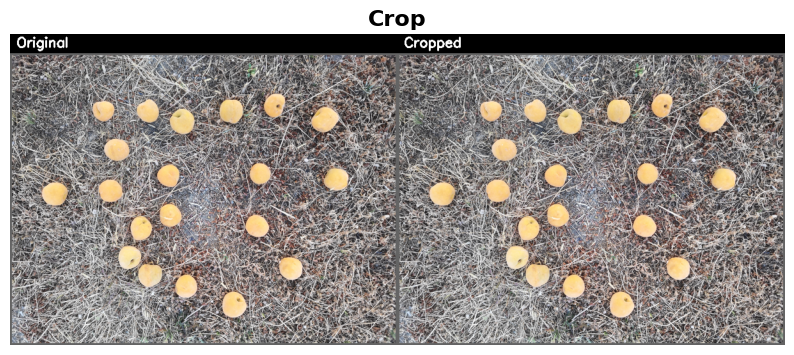

In [6]:
# Crop image to maintain desired aspect ratio
print(f'    Cropping image to aspect ratio {cfg.aspect_ratio[0]}x{cfg.aspect_ratio[1]}:')
img_crop = utils_cv.crop_image_to_aspect_ratio(img_original, cfg.aspect_ratio)
print(f'    Original Size: {img_original.shape}    Cropped Size: {img_crop.shape}')
utils_cv.show_mosaic([img_original, img_crop], headers=['Original', 'Cropped'], window_name='Crop')

    Cropped Size: (2736, 3648, 3)    Reduced Size: (1152, 1536, 3)


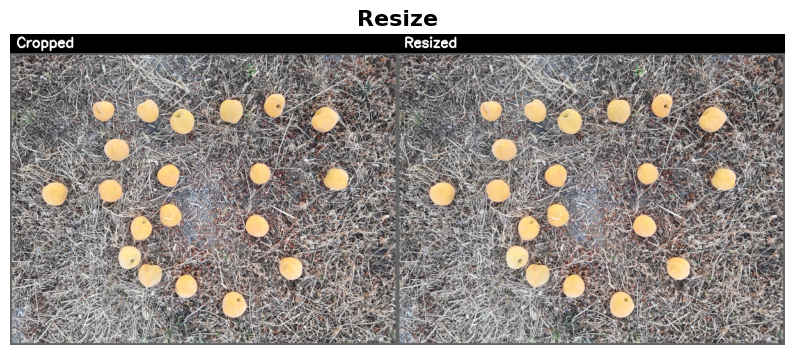

In [7]:
# Resize image to maximum resolution
img_reduced = utils_cv.resize_image(img_crop, cfg.max_resolution)
print(f'    Cropped Size: {img_crop.shape}    Reduced Size: {img_reduced.shape}')

utils_cv.show_mosaic([img_crop, img_reduced], headers=['Cropped', 'Resized'], window_name='Resize')

## 5. Color Smoothing
   - Applies color smoothing to reduce noise and enhance the clarity of target objects.

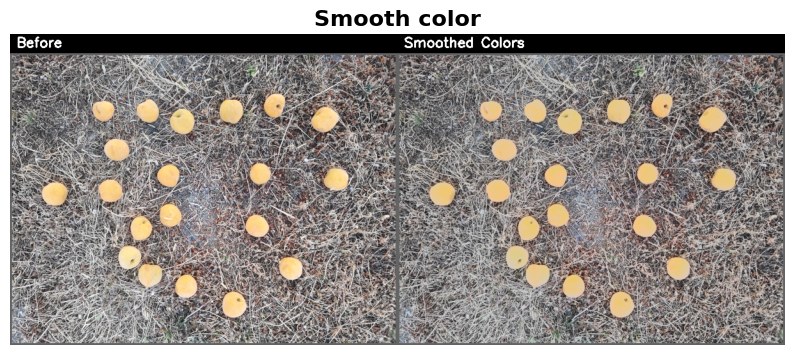

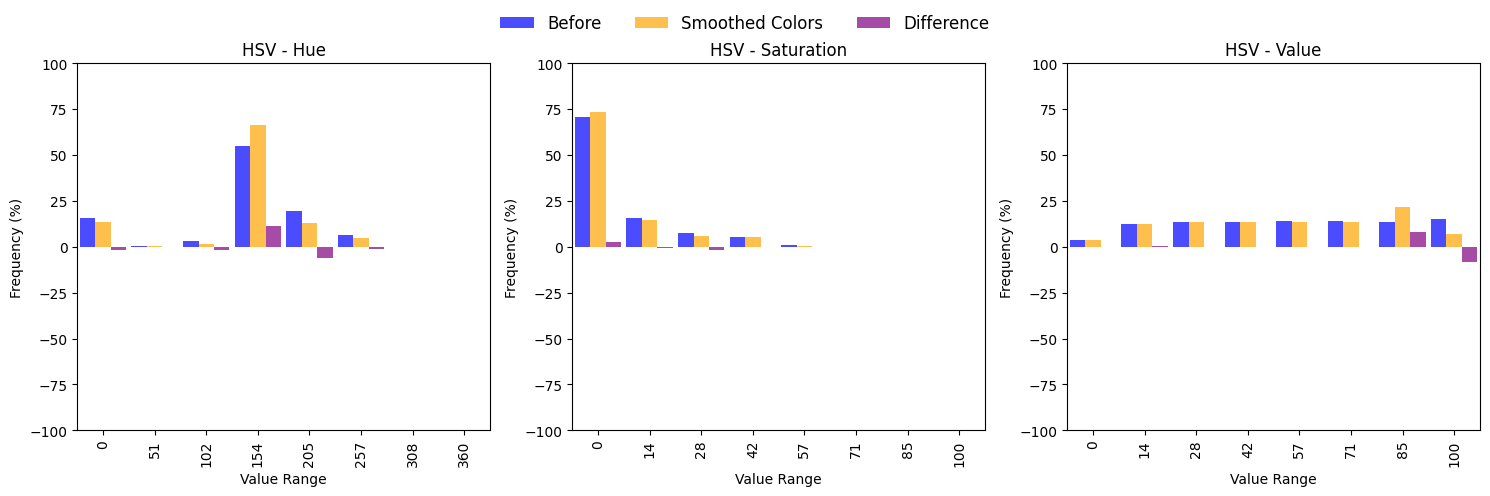

In [8]:
# Apply color smoothing if configured
if cfg.smooth_colors == 0:
    print('    Skipping Smooth Color')
    img_smooth_color = img_reduced
else:
    img_smooth_color = utils_cv.smooth_color(img_reduced, kernel_size=cfg.smooth_colors, min_brightness=20, max_brightness=210)

    utils_cv.show_mosaic([img_reduced, img_smooth_color], 
                headers=['Before', 'Smoothed Colors'],
                window_name=f'Smooth color')
        

    utils_cv.show_histograms(img_reduced, img_smooth_color, color_spaces=["HSV"], legend="Smoothed Colors")

## 6. Color Amplification
   - Enhances the saturation of specific hues to make target objects more distinguishable from the background.

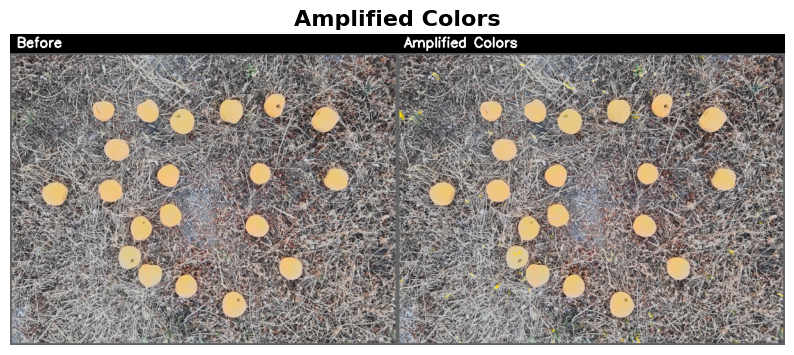

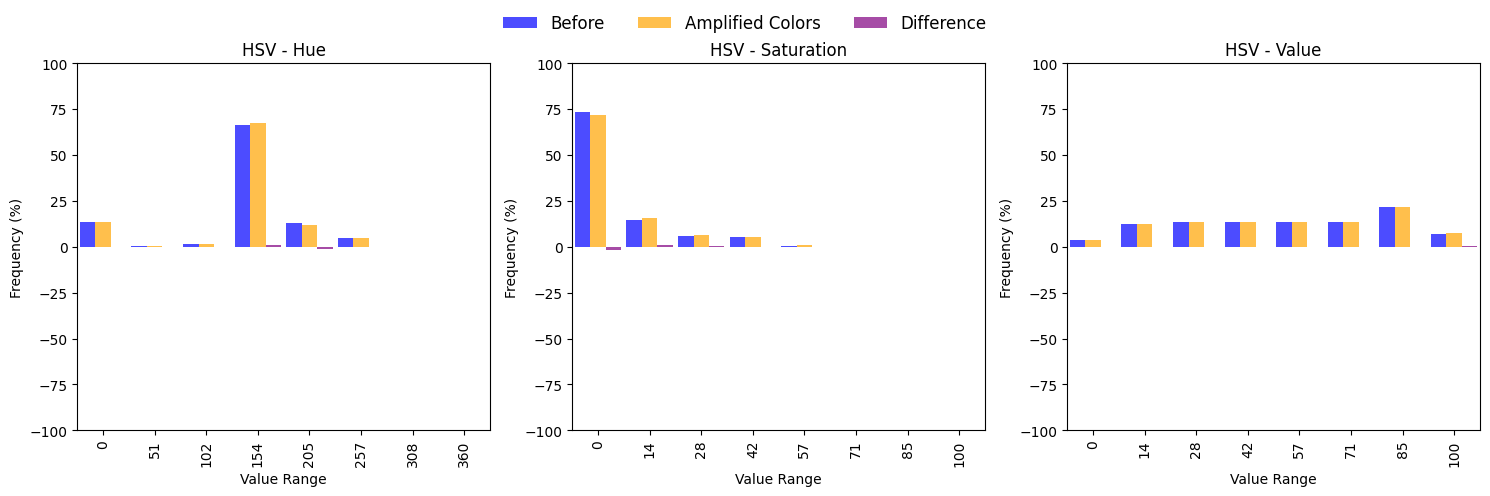

In [9]:
    # Amplify saturation around a specific hue to enhance target objects
    cfg.color_amplify_hue, cfg.color_amplify_range, cfg.color_amplify_increase = (51, 10, 15)
    if cfg.color_amplify_range == 0:
        print('    Skipping Amplify Color')
        img_amplified = img_smooth_color
    else:
        img_amplified = utils_cv.amplify_saturation_near_hue(img_smooth_color, cfg.color_amplify_hue, cfg.color_amplify_range, cfg.color_amplify_increase)
        
        utils_cv.show_mosaic([img_smooth_color, img_amplified],
                    headers=['Before', 'Amplified Colors'],
                    window_name=f'Amplified Colors')
    
        utils_cv.show_histograms(img_smooth_color, img_amplified, color_spaces=["HSV"], legend="Amplified Colors")


## 7. Texture Removal
   - Utilizes morphological operations to detect and remove textures that may interfere with object detection.
   - Processes multiple texture layers to ensure clean segmentation.

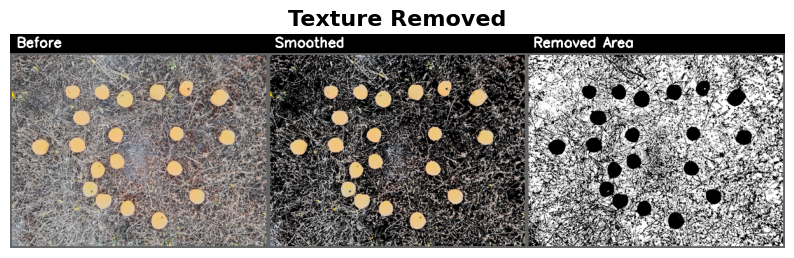

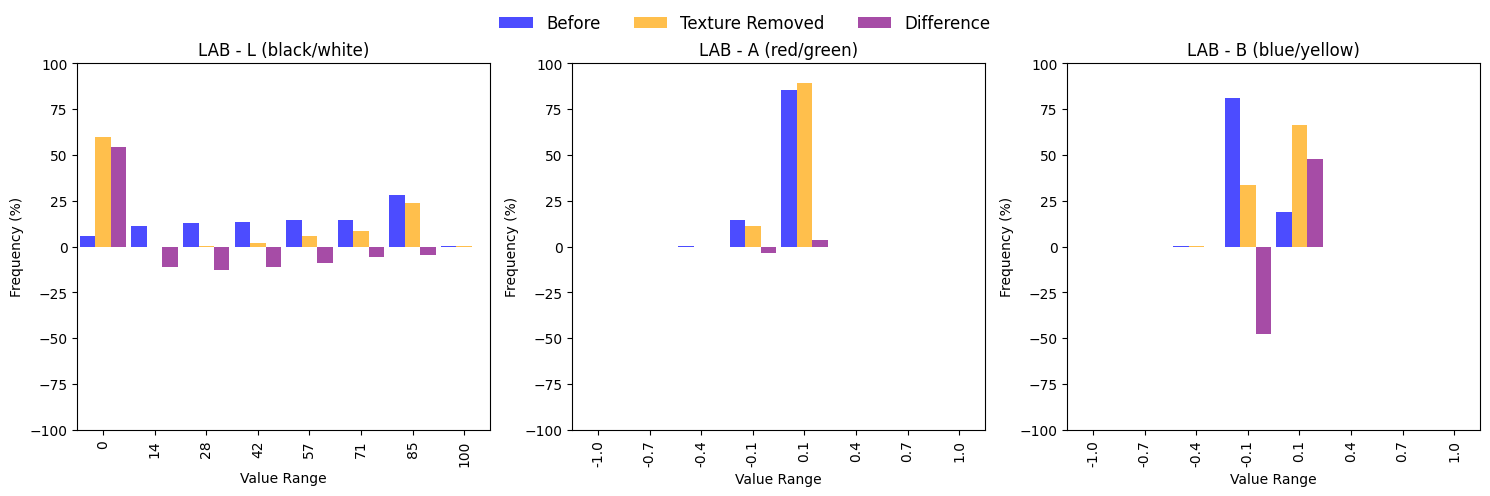

In [10]:
# Remove texture using morphological operations if configured
if cfg.texture_1_kernel_size <= 1:
    print('   Skipping Texture 1')
    img_texture = img_amplified
else:
    img_texture, mask = utils_cv.detect_smooth_areas_rgb(img_amplified, 
                                kernel_size=cfg.texture_1_kernel_size, 
                                threshold_value=cfg.texture_1_threshold_value, 
                                noise=cfg.texture_1_noise, 
                                expand=cfg.texture_1_expand, 
                                it=cfg.texture_1_it)
    
    utils_cv.show_mosaic([img_amplified, img_texture, ~mask],
                headers=['Before', 'Smoothed', 'Removed Area'],
                window_name=f'Texture Removed')

    utils_cv.show_histograms(img_amplified, img_texture, color_spaces=["LAB"], legend="Texture Removed")

## 8. CLAHE
   - Applies Contrast Limited Adaptive Histogram Equalization (CLAHE) for contrast enhancement.
   - Removes salt-and-pepper noise and applies Gaussian blur to further smooth the image.

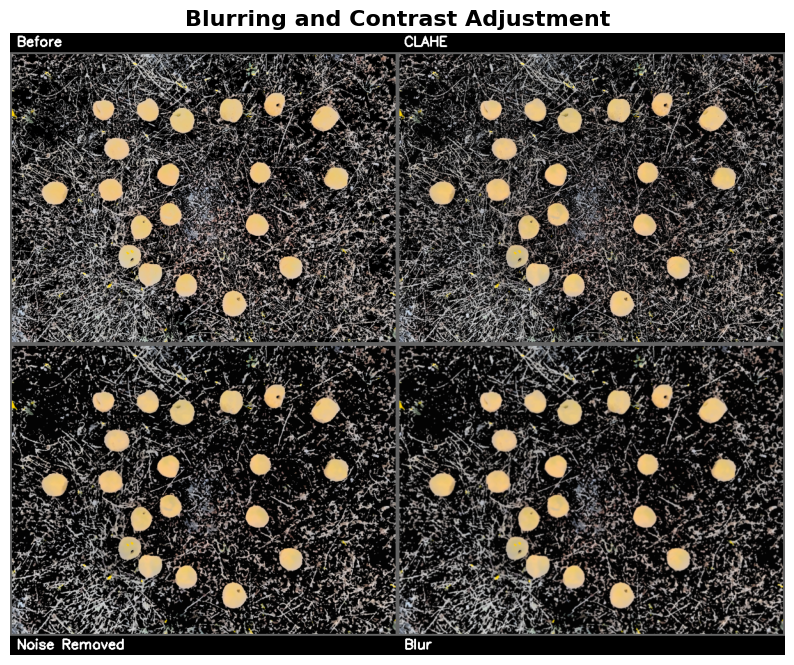

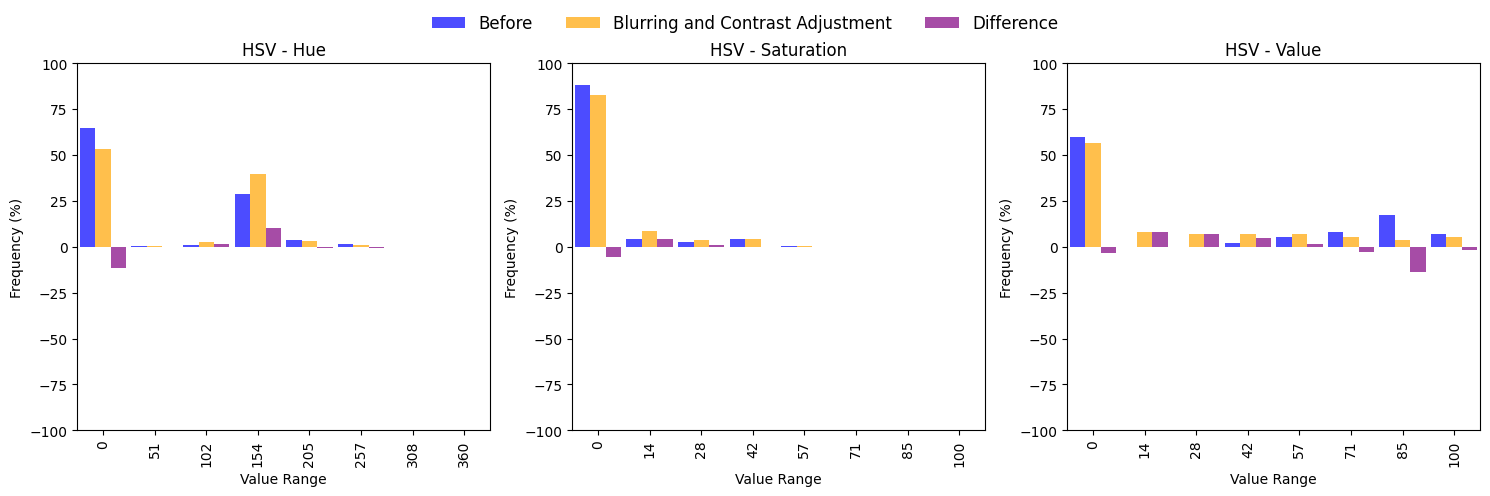

In [11]:
# Apply CLAHE, remove noise, and apply Gaussian blur
_, img_clahe, _ = utils_cv.apply_clahe(img_texture, 
                            tileGridSize=(cfg.blur_clahe_grid, cfg.blur_clahe_grid), 
                            clipLimit=cfg.blur_clahe_limit)
img_noise = utils_cv.remove_salt_and_pepper(img_clahe, kernel_size=cfg.blur_salt_pepper)
img_blur = utils_cv.blur_image(img_noise, kernel_size=cfg.blur_size)


utils_cv.show_mosaic([img_texture, img_clahe, img_noise, img_blur],
            mosaic_dims=(2,2),
            headers=['Before', 'CLAHE'],
            footers=['Noise Removed', 'Blur'],
            window_name=f'Blurring and Contrast Adjustment')

utils_cv.show_histograms(img_texture, img_blur, color_spaces=["HSV"], legend="Blurring and Contrast Adjustment")

## 9. Foreground Selection
   - Combines multiple color filters to create a comprehensive mask highlighting the foreground objects.
   - Differentiates between certain and probable object regions for more accurate detection.

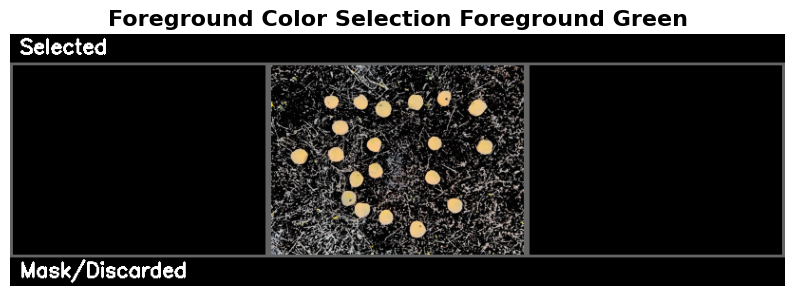

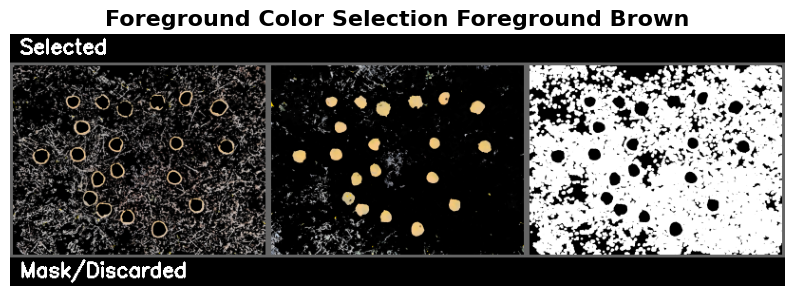

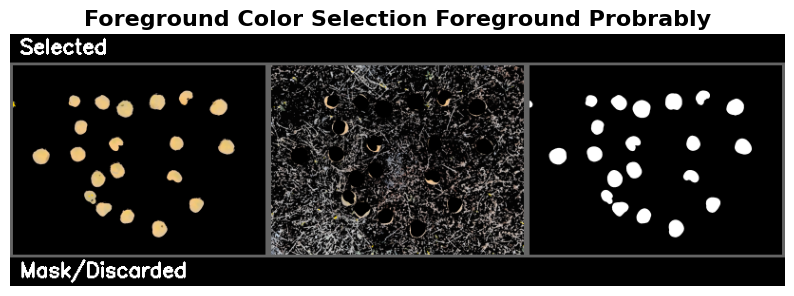

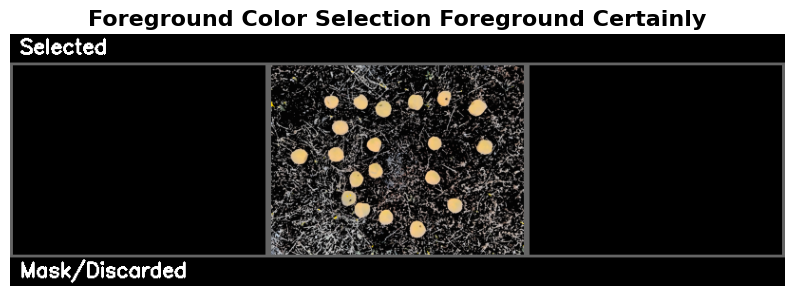

In [12]:
img_before = img_blur
img_tmp = img_before
mask_tmp = np.zeros(img_tmp.shape[:2], dtype=np.int8)

# Iterate through the list of foreground colors to create masks
for i in range(len(cfg.foreground_list)):
    cfg.foreground_name = cfg.foreground_list[i][0][0]
    cfg.foreground_weight = cfg.foreground_list[i][0][1]
    color_space = 'LAB' if 'LAB' in cfg.foreground_name else 'HSV'

    if cfg.foreground_weight != 0:
        selected_area, discarded_area, mask_selected = utils_cv.filter_color(img_tmp, 
                                                        color_ini=cfg.foreground_list[i][1][0:3], 
                                                        color_end=cfg.foreground_list[i][1][3:6],  
                                                        noise=cfg.foreground_list[i][1][6],
                                                        expand=cfg.foreground_list[i][1][7],
                                                        close=cfg.foreground_list[i][1][8],
                                                        iterations=cfg.foreground_list[i][1][9],
                                                        color_space=color_space)

        utils_cv.show_mosaic([selected_area, discarded_area, mask_selected], 
                    mosaic_dims=(1, 3),
                    headers=['Selected'],
                    footers=['Mask/Discarded'],
                    window_name=f'Foreground Color Selection {cfg.foreground_name}',
                    max_resolution=800)
        
        # Accumulate mask weights based on configuration
        mask_tmp += np.where(mask_selected > 0, cfg.foreground_weight, 0)

        del selected_area, discarded_area, mask_selected
    print('')

# Create a binary foreground mask
mask_foreground = np.where(mask_tmp >= 1, 255, 0).astype('uint8')
if '' in cfg.profile:
    mask_foreground = utils_cv.expand_mask_circle(mask_foreground, kernel_size=7, iterations=1)

# Apply the foreground mask to the smoothed color image
img_foreground = cv2.bitwise_and(img_smooth_color, img_smooth_color, mask=mask_foreground)
img_background = cv2.bitwise_and(img_smooth_color, img_smooth_color, mask=~mask_foreground)

As brighter the mask is, more probrably it is an object:


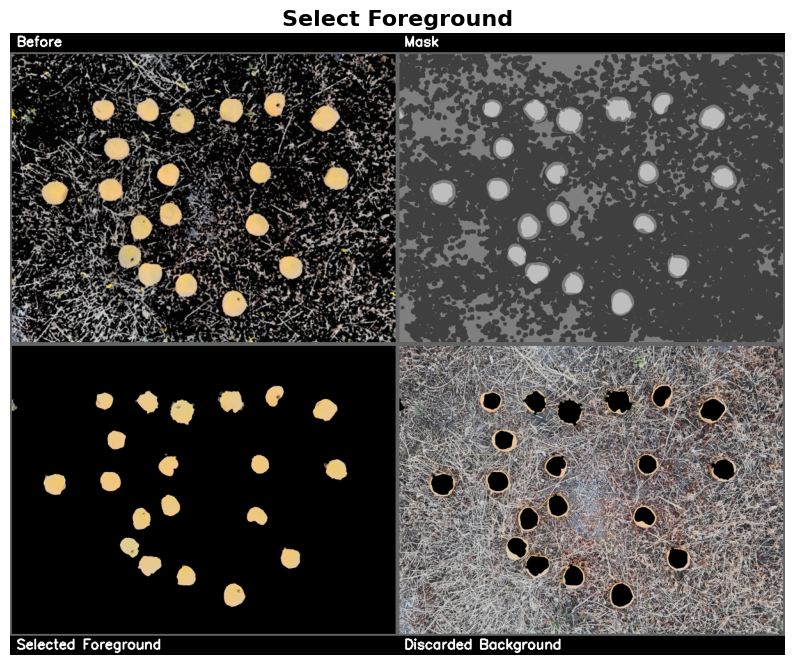

In [13]:
print("As brighter the mask is, more probrably it is an object:")
mask_normal = utils_cv.normalize_mask_to_uin8(mask_tmp)

utils_cv.show_mosaic([img_before, mask_normal, img_foreground, img_background],
                     mosaic_dims=(2,2),
                     headers=['Before', 'Mask'],
                     footers=['Selected Foreground', 'Discarded Background'],
                     window_name=f'Select Foreground')

#### 10. Quantization
        - Applies K-Means clustering to reduce the color palette, simplifying color variations and potentially improving detection accuracy.


Applying KMeans
Coloring Viridis
Recoloring based on original
KMeans finished


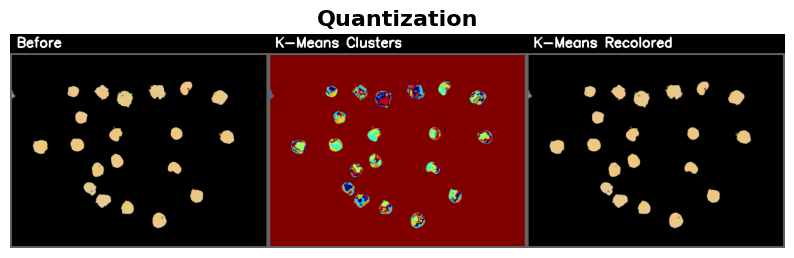

In [14]:
# Apply K-Means color quantization if configured
if cfg.quantization_n_colors == 0:
    debug_print('    Skipping Quantization')
    img_quantization = img_foreground
else:
    # Perform color quantization
    img_preprocessed, clustered_rgb, clustered_labels = utils_cv.kmeans_recolor(img_foreground, n_clusters=cfg.quantization_n_colors)

    utils_cv.show_mosaic([img_foreground, clustered_rgb, img_preprocessed], 
                headers=['Before', 'K-Means Clusters', 'K-Means Recolored'], 
                window_name='Quantization')
            

# Result of Preprocessing

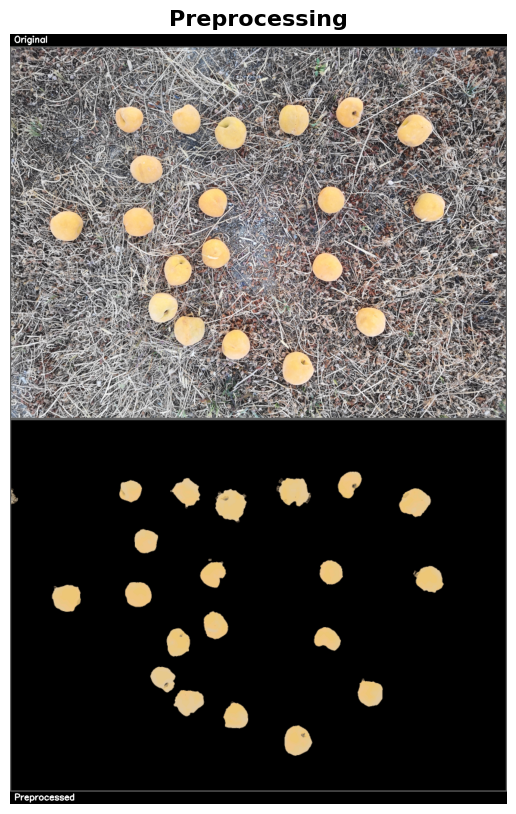

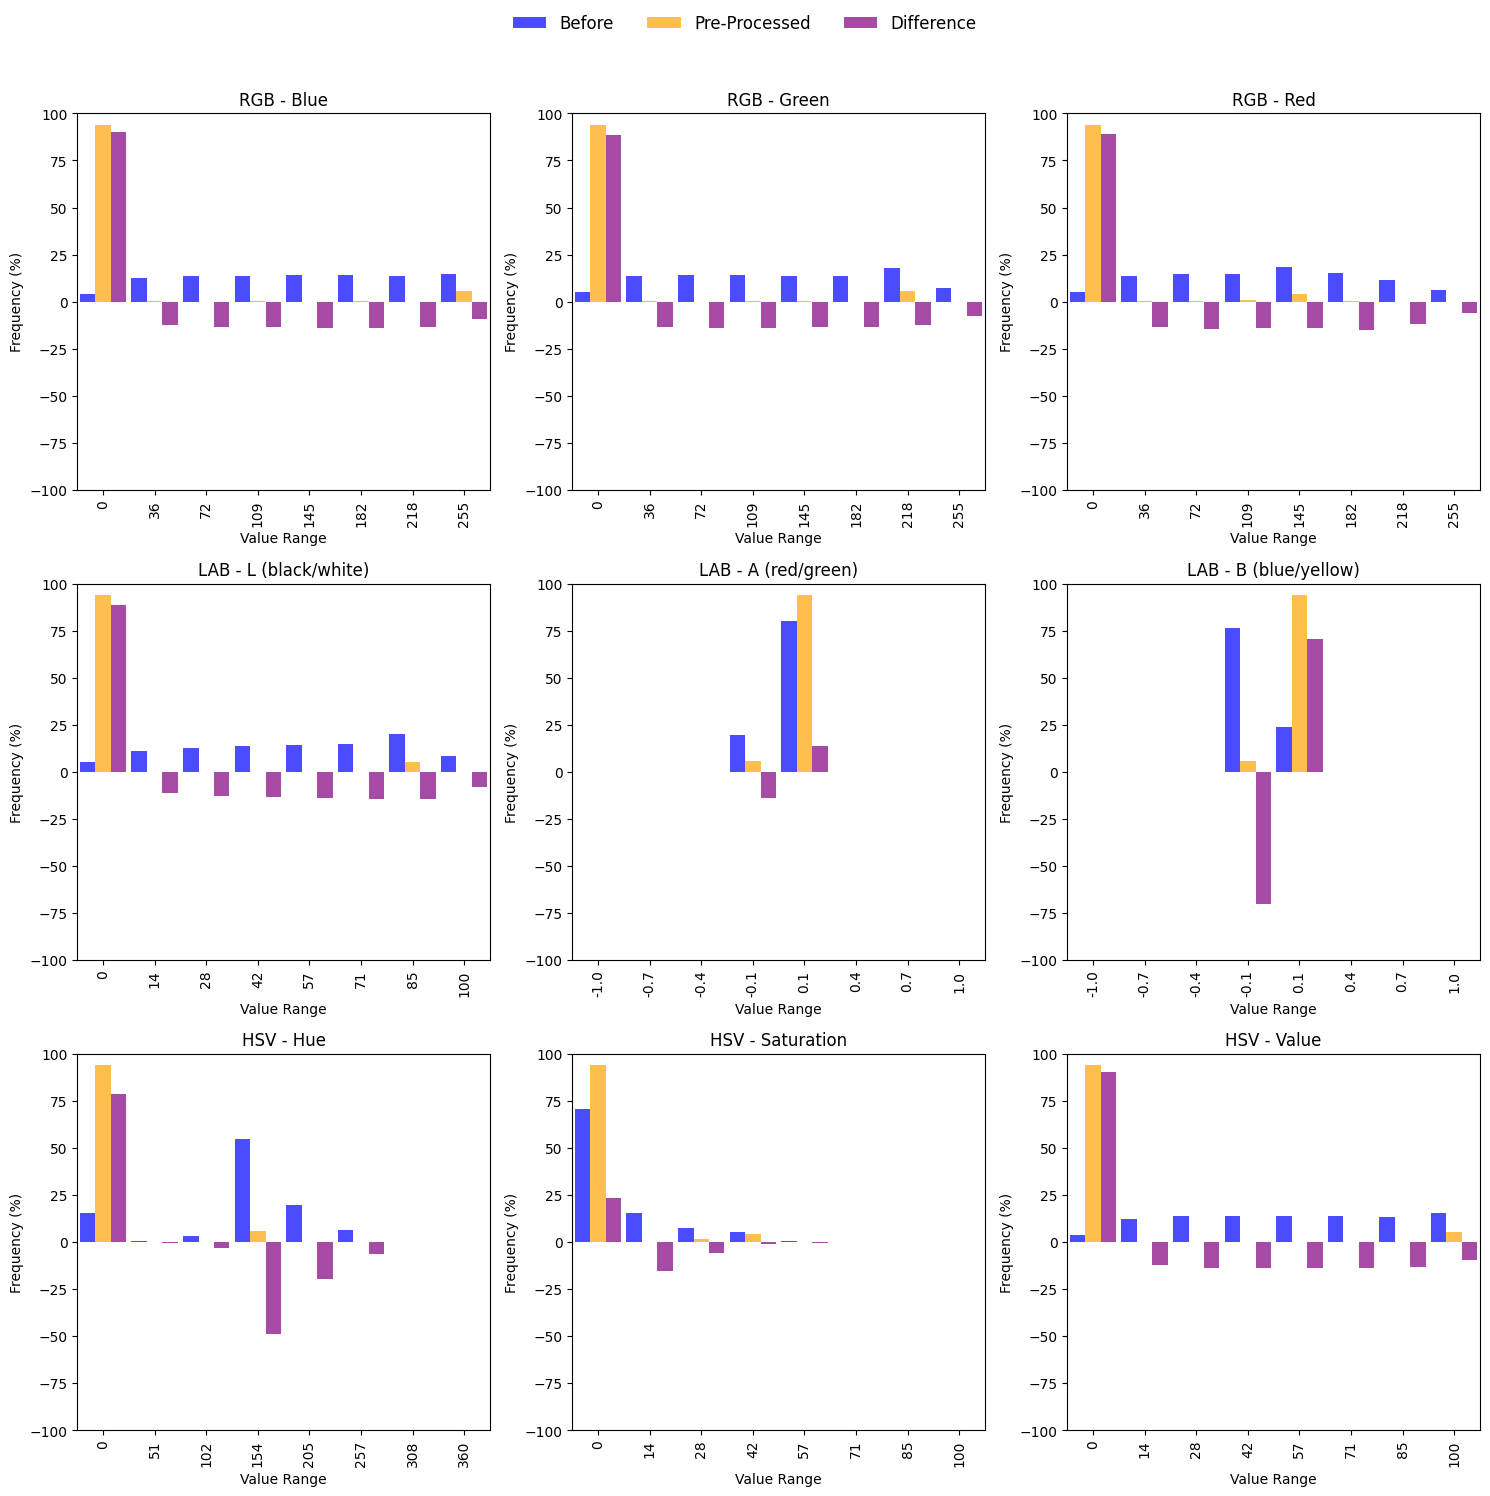

In [15]:
utils_cv.show_mosaic([img_reduced, img_preprocessed], 
            mosaic_dims=(2,1),
            headers=['Original'], 
            footers=['Preprocessed'], 
            window_name='Preprocessing')

utils_cv.show_histograms(img_reduced, img_preprocessed, legend="Pre-Processed")

# Batch test:

config_profiles.set_batch_mode(True)
config_profiles.set_notebook_mode(True)
config_profiles.set_print_report_on_image(True)
config_profiles.set_debug_level(1)

accuracy_summaries = []
accuracy_summaries.append(main.test_directory(r"/kaggle/input/fruit-count/test_images", 'YELLOW_PEACH'))

for summary in accuracy_summaries:
    print(summary)        